In [ ]:
####导入数据，找到配对股票

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from jqdatasdk import *
auth('18827513013','513013')

auth success  ( 聚宽第二届高频因子挑战赛正式启动，欢迎来战。详情查看大赛官方网页：http://suo.im/4SbA8A )


In [ ]:
# 获取沪深300指数成分股 前复权后的历史股价 副本1.csv 
index = '000300.XSHG'
start = '2017-11-1'
end   = '2019-10-31'
code_list = get_index_stocks(index)
index_df = get_price(code_list, start, end, fields='close').close
index_df.to_csv('C:/Users/YH/Desktop/副本/副本1.csv')
index_df.head()

In [3]:
len(index_df)   #总共有487行数据

487

In [ ]:
df=index_df.dropna(axis = 1)    #axis = 1代表删除缺失值所在的列，这个案例里，删除了有缺失值的股票代码    
df.to_csv('C:/Users/YH/Desktop/副本/副本2.csv')             #dropna默认删除缺失值所在的行，也就是默认axis=0
df.head()

In [5]:
np.isnan(df).any().sum() #检查数据集里是否还有缺失值

0

In [ ]:
df_log=np.log(df)   #对数据取对数
df_log.to_csv('C:/Users/YH/Desktop/副本/副本对数.csv')
df_log.head()

In [ ]:
train=df_log.loc["2017-11-1":"2018-10-31"]#2017-11-01至2018-10-31为训练+验证数据，共244个数据（先用这部分数据选出相关系数高的股票对）  
train.to_csv('C:/Users/YH/Desktop/副本/副本train.csv')         
train.head()
train.tail()

In [8]:
len(train)

244

In [ ]:
test=df_log.loc["2018-11-1":]   #用来预测
test.head()

In [25]:
len(test)

243

In [9]:
import pandas as pd             # 计算每支股票与其余股票的相关系数，降序排列
from numpy import nan           # 相关系数相等的两支股票即为配对股票 
import numpy as np              # 没有组成配对的股票是由于它与已组成配对的股票的相关系数低于已组成的股票对的相关系数
corr_df = train.corr()
corr_df[corr_df==1] = nan
corr_df = pd.DataFrame(corr_df.max().sort_values(ascending=False).head(10), columns=['corr'])
corr_df['name'] = [get_security_info(code).display_name for code in corr_df.index]
corr_df['industry'] = [get_industry(code) for code in corr_df.index] 
corr_df.to_csv('C:/Users/YH/Desktop/副本/副本配对股票1.csv')
corr_df                    #得到配对股票

,corr,name,industry
601555.XSHG,0.995504,东吴证券,{'601555.XSHG': {'sw_l1': {'industry_code': '8...
000728.XSHE,0.995504,国元证券,{'000728.XSHE': {'sw_l1': {'industry_code': '8...
600109.XSHG,0.992102,国金证券,{'600109.XSHG': {'sw_l1': {'industry_code': '8...
600837.XSHG,0.991892,海通证券,{'600837.XSHG': {'sw_l1': {'industry_code': '8...
000783.XSHE,0.991892,长江证券,{'000783.XSHE': {'sw_l1': {'industry_code': '8...
600958.XSHG,0.991009,东方证券,{'600958.XSHG': {'sw_l1': {'industry_code': '8...
601377.XSHG,0.988972,兴业证券,{'601377.XSHG': {'sw_l1': {'industry_code': '8...
601878.XSHG,0.988972,浙商证券,{'601878.XSHG': {'sw_l1': {'industry_code': '8...
600061.XSHG,0.988791,国投资本,{'600061.XSHG': {'sw_l1': {'industry_code': '8...
601211.XSHG,0.988262,国泰君安,{'601211.XSHG': {'sw_l1': {'industry_code': '8...


In [ ]:
####检验配对股票的协整关系

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *

D:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support '000728.XSHE' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


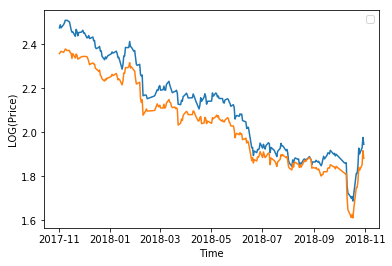

In [11]:
GY=train['000728.XSHE'] #取对数后的train训练集中国元证券和东吴证券走势相近
DW=train['601555.XSHG']  #东吴证券
plot(GY);plot(DW)
plt.xlabel('Time');plt.ylabel('LOG(Price)')
plt.legend(['000728.XSHE'],['601555.XSHG'],loc='best')

In [12]:
#综上可以看到  东吴证券和长江证券一阶单整  可以做协整检验
import statsmodels.api as sm           #协整检验  先做一元回归   再对残差做单位根检验
import seaborn as sns
x = train['000728.XSHE']
y = train['601555.XSHG']
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

C:\Users\YH\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            601555.XSHG   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.673e+04
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          1.02e-249
Time:                        20:31:06   Log-Likelihood:                 630.83
No. Observations:                 244   AIC:                            -1258.
Df Residuals:                     242   BIC:                            -1251.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1685      0.012     14.590      

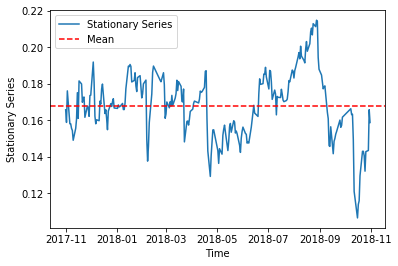

In [13]:
plot(y-0.8858*x);              #根据ols的估计系数，画出y-0.8858*x的平稳序列
plt.axhline((y-0.8858*x).mean(), color="red", linestyle="--")
plt.xlabel("Time"); plt.ylabel("Stationary Series")
plt.legend(["Stationary Series", "Mean"])

In [14]:
from statsmodels.tsa.stattools import adfuller        #单位根检验P<0.05 说明平稳
adftest=adfuller(y-0.8858*x-0.1575)                   #东吴证券和国元证券之间存在着长期的均衡关系
result=pd.Series(adftest[0:4],index=['Test Statistic','p-value','Lags Used','Numbers of Observations Used'])
for key,value in adftest[4].items():
    result['Critical Value (%s)'%key]=value
print(result)                                 #残差的单位根检验

Test Statistic                   -3.695034
p-value                           0.004184
Lags Used                         1.000000
Numbers of Observations Used    242.000000
Critical Value (1%)              -3.457664
Critical Value (5%)              -2.873559
Critical Value (10%)             -2.573175
dtype: float64


In [ ]:
####计算价差，训练模型

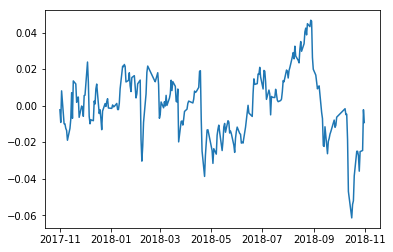

In [20]:
spread=y-0.8858*x-mean(y-0.8858*x)
plot(spread)

In [21]:
spread.head()

2017-11-01   -0.002285
2017-11-02   -0.009210
2017-11-03    0.008068
2017-11-06   -0.009945
2017-11-07   -0.009967
dtype: float64

In [17]:
spread.size

244

In [ ]:
####

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


X:[0.54705309 0.48305861 0.64272133 0.47626863 0.47606206 0.453027
 0.44254047 0.39288342 0.45299622 0.49969101],Y:0.6337127929877767
X:[0.48305861 0.64272133 0.47626863 0.47606206 0.453027   0.44254047
 0.39288342 0.45299622 0.49969101 0.63371279],Y:0.503784706923388
X:[0.64272133 0.47626863 0.47606206 0.453027   0.44254047 0.39288342
 0.45299622 0.49969101 0.63371279 0.50378471],Y:0.6930372397045059
X:[0.47626863 0.47606206 0.453027   0.44254047 0.39288342 0.45299622
 0.49969101 0.63371279 0.50378471 0.69303724],Y:0.677691682076286
X:[0.47606206 0.453027   0.44254047 0.39288342 0.45299622 0.49969101
 0.63371279 0.50378471 0.69303724 0.67769168],Y:0.5848583979316515
X:[0.453027   0.44254047 0.39288342 0.45299622 0.49969101 0.63371279
 0.50378471 0.69303724 0.67769168 0.5848584 ],Y:0.6088169533083699
X:[0.44254047 0.39288342 0.45299622 0.49969101 0.63371279 0.50378471
 0.69303724 0.67769168 0.5848584  0.60881695],Y:0.6115305872526232
X:[0.39288342 0.45299622 0.49969101 0.63371279 0.503

 0.42317621 0.3783417  0.38314252 0.37866606],Y:0.459440703757467
X:[0.33145922 0.40358344 0.43755585 0.4594135  0.42725337 0.42317621
 0.3783417  0.38314252 0.37866606 0.4594407 ],Y:0.4956996497574775
X:[0.40358344 0.43755585 0.4594135  0.42725337 0.42317621 0.3783417
 0.38314252 0.37866606 0.4594407  0.49569965],Y:0.5346338033050704
X:[0.43755585 0.4594135  0.42725337 0.42317621 0.3783417  0.38314252
 0.37866606 0.4594407  0.49569965 0.5346338 ],Y:0.5696316355234305
X:[0.4594135  0.42725337 0.42317621 0.3783417  0.38314252 0.37866606
 0.4594407  0.49569965 0.5346338  0.56963164],Y:0.5305041284975612
X:[0.42725337 0.42317621 0.3783417  0.38314252 0.37866606 0.4594407
 0.49569965 0.5346338  0.56963164 0.53050413],Y:0.5133538551579722
X:[0.42317621 0.3783417  0.38314252 0.37866606 0.4594407  0.49569965
 0.5346338  0.56963164 0.53050413 0.51335386],Y:0.6285515281888361
X:[0.3783417  0.38314252 0.37866606 0.4594407  0.49569965 0.5346338
 0.56963164 0.53050413 0.51335386 0.62855153],Y:0.70

Train on 189 samples, validate on 33 samples
Epoch 1/20
 - 9s - loss: 0.1474 - val_loss: 0.0370
Epoch 2/20
 - 2s - loss: 0.0367 - val_loss: 0.0420
Epoch 3/20
 - 2s - loss: 0.0274 - val_loss: 0.0339
Epoch 4/20
 - 2s - loss: 0.0299 - val_loss: 0.0407
Epoch 5/20
 - 2s - loss: 0.0258 - val_loss: 0.0454
Epoch 6/20
 - 2s - loss: 0.0205 - val_loss: 0.0496
Epoch 7/20
 - 2s - loss: 0.0207 - val_loss: 0.0446
Epoch 8/20
 - 2s - loss: 0.0191 - val_loss: 0.0407
Epoch 9/20
 - 2s - loss: 0.0186 - val_loss: 0.0403
Epoch 10/20
 - 2s - loss: 0.0185 - val_loss: 0.0472
Epoch 11/20
 - 2s - loss: 0.0194 - val_loss: 0.0442
Epoch 12/20
 - 2s - loss: 0.0193 - val_loss: 0.0469
Epoch 13/20
 - 2s - loss: 0.0147 - val_loss: 0.0357
Epoch 14/20
 - 2s - loss: 0.0154 - val_loss: 0.0370
Epoch 15/20
 - 2s - loss: 0.0127 - val_loss: 0.0388
Epoch 16/20
 - 2s - loss: 0.0142 - val_loss: 0.0355
Epoch 17/20
 - 2s - loss: 0.0164 - val_loss: 0.0382
Epoch 18/20
 - 2s - loss: 0.0158 - val_loss: 0.0362
Epoch 19/20
 - 2s - loss: 0.

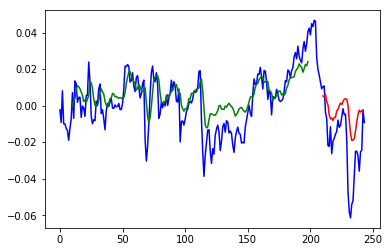

In [22]:
seed=7
batch_size=1
epochs=20    #迭代10次
filename=spread
footer=3
look_back=10   #用前十次的数据来预测下一时刻的数据 
lr=0.0006
def create_dataset(dataset):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        x=dataset[i:i+look_back,0]
        dataX.append(x)
        y=dataset[i+look_back,0]
        dataY.append(y)
        print('X:%s,Y:%s'%(x,y))
    return np.array(dataX),np.array(dataY)

def build_model():
    model=Sequential()
    model.add(LSTM(units=10,input_shape=(1,look_back),return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=10,return_sequences=False))
    model.add(Dropout(0.25))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

if __name__=='__main__':
    
    #设置随机数种子
    np.random.seed(seed)
    
    #导入数据
    data=filename
    dataset=data.values.astype('float64')
    
    #标准化数据
    scaler=MinMaxScaler()
    dataset=scaler.fit_transform(dataset.reshape(-1,1))
    train_size=len(dataset[0:200])    
    validation_size=len(dataset)-train_size
    train,validation=dataset[0: train_size, :],dataset[train_size:len(dataset), :]
    
    #创建dataset,让数据产生相关性
    X_train,y_train=create_dataset(train)
    X_validation,y_validation=create_dataset(validation)
    
    #将输入转化成【样本，时间步长，特征】
    X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
    X_validation=np.reshape(X_validation,(X_validation.shape[0],1,X_validation.shape[1]))
    
    #训练模型
    model=build_model()
    model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=2,validation_data=(X_validation,y_validation))
    
    #模型预测数据
    predict_train=model.predict(X_train)
    predict_validation=model.predict(X_validation)
    
    #反标准化数据，目的是保证MSE的准确性
    predict_train=scaler.inverse_transform(predict_train)
    y_train=scaler.inverse_transform([y_train])
    predict_validation=scaler.inverse_transform(predict_validation)
    y_validation=scaler.inverse_transform([y_validation])
    
    #评估模型
    train_score=math.sqrt(mean_squared_error(y_train[0],predict_train[:, 0]))
    print('Train Score: %.2f RMSE' % train_score)
    validation_score=math.sqrt(mean_squared_error(y_validation[0],predict_validation[:, 0]))
    print('Validation Score: %.2f RMSE' % validation_score)
    
    #构建通过训练数据集进行预测的图表数据
    predict_train_plot=np.empty_like(dataset)
    predict_train_plot[:, :]=np.nan
    predict_train_plot[look_back:len(predict_train)+look_back, :]=predict_train
    
    #构建通过评估数据集进行预测的图表数据
    predict_validation_plot=np.empty_like(dataset)
    predict_validation_plot[:, :]=np.nan
    predict_validation_plot[len(predict_train)+look_back*2+1:len(dataset)-1, :]=predict_validation
    
    #图表显示
    dataset=scaler.inverse_transform(dataset)
    plt.plot(dataset,color='blue')
    plt.plot(predict_train_plot,color='green')
    plt.plot(predict_validation_plot,color='red')
    plt.show()

In [26]:
fx=test['000728.XSHE']            #测试集的价差
fy=test['601555.XSHG']
fspread=fy-0.8858*fx-mean(fy-0.8858*fx)

X:[0.06754794 0.10546446 0.09647042 0.10197825 0.15356653 0.11377202
 0.12728072 0.15264596 0.24825341 0.24378636],Y:0.26259149308345886
X:[0.10546446 0.09647042 0.10197825 0.15356653 0.11377202 0.12728072
 0.15264596 0.24825341 0.24378636 0.26259149],Y:0.23088488521459868
X:[0.09647042 0.10197825 0.15356653 0.11377202 0.12728072 0.15264596
 0.24825341 0.24378636 0.26259149 0.23088489],Y:0.04857721884427929
X:[0.10197825 0.15356653 0.11377202 0.12728072 0.15264596 0.24825341
 0.24378636 0.26259149 0.23088489 0.04857722],Y:0.04720230806939135
X:[0.15356653 0.11377202 0.12728072 0.15264596 0.24825341 0.24378636
 0.26259149 0.23088489 0.04857722 0.04720231],Y:0.06586687738573482
X:[0.11377202 0.12728072 0.15264596 0.24825341 0.24378636 0.26259149
 0.23088489 0.04857722 0.04720231 0.06586688],Y:0.07525684071138261
X:[0.12728072 0.15264596 0.24825341 0.24378636 0.26259149 0.23088489
 0.04857722 0.04720231 0.06586688 0.07525684],Y:0.06508768830576234
X:[0.15264596 0.24825341 0.24378636 0.262

X:[0.73018014 0.62583286 0.53171041 0.56749507 0.66776778 0.65797678
 0.56140238 0.59411712 0.62619788 0.64469806],Y:0.654610135103066
X:[0.62583286 0.53171041 0.56749507 0.66776778 0.65797678 0.56140238
 0.59411712 0.62619788 0.64469806 0.65461014],Y:0.6796719343696213
X:[0.53171041 0.56749507 0.66776778 0.65797678 0.56140238 0.59411712
 0.62619788 0.64469806 0.65461014 0.67967193],Y:0.7414935778761043
X:[0.56749507 0.66776778 0.65797678 0.56140238 0.59411712 0.62619788
 0.64469806 0.65461014 0.67967193 0.74149358],Y:0.7547277152177937
X:[0.66776778 0.65797678 0.56140238 0.59411712 0.62619788 0.64469806
 0.65461014 0.67967193 0.74149358 0.75472772],Y:0.6796230328889361
X:[0.65797678 0.56140238 0.59411712 0.62619788 0.64469806 0.65461014
 0.67967193 0.74149358 0.75472772 0.67962303],Y:0.6733839863277467
X:[0.56140238 0.59411712 0.62619788 0.64469806 0.65461014 0.67967193
 0.74149358 0.75472772 0.67962303 0.67338399],Y:0.6438220026699326
X:[0.59411712 0.62619788 0.64469806 0.65461014 0.

Test Score: 0.07 RMSE


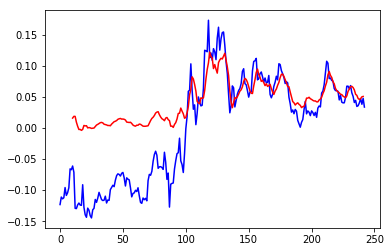

In [29]:
XY=fspread         #根据训练好的模型进行预测
dataset=XY.values.astype('float64')
#标准化数据
scaler=MinMaxScaler()
dataset=scaler.fit_transform(dataset.reshape(-1,1))
    
#创建dataset,让数据产生相关性
X_test,y_test=create_dataset(dataset)
    
#将输入转化成【样本，时间步长，特征】
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))


#模型预测数据
predict_test=model.predict(X_test)
    
#反标准化数据，目的是保证MSE的准确性
predict_test=scaler.inverse_transform(predict_test)
y_test=scaler.inverse_transform([y_test])
    
#评估模型
test_score=math.sqrt(mean_squared_error(y_test[0],predict_test[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

#构建通过测试数据集进行预测的图表数据
predict_test_plot=np.empty_like(dataset)
predict_test_plot[:, :]=np.nan
predict_test_plot[look_back:len(predict_test)+look_back, :]=predict_test

#图表显示
dataset=scaler.inverse_transform(dataset)
plt.plot(dataset,color='blue')
plt.plot(predict_test_plot,color='red')
plt.show()



In [ ]:
delta_pred1=predict_test[:, 0]-y_test[0]      #测试集的符号正确率
delta1=y_test[:, 0]-y_test[0]
Z2=delta_pred1*delta1
sum(Z2>0)            #SA是符号正确率
SA=sum(Z2>0)/delta1.size
SA

In [ ]:
delta_s_pred_t=predict_train[:, 0]-y_train[0]       #训练集的符号正确率
delta_s_pred_t
delta_s_t=y_train[:, 0]-y_train[0]
Z=delta_s_pred_t*delta_s_t
Z
sum(Z>0)            #SA是符号正确率
SA=sum(Z>0)/delta_s_t.size
SA

In [ ]:
delta_pred=predict_validation[:, 0]-y_validation[0]     #验证集的符号正确率
delta=y_validation[:, 0]-y_validation[0]
Z1=delta_pred*delta
sum(Z1>0)            #SA是符号正确率
SA=sum(Z1>0)/delta.size
SA